In [79]:
import requests
import json
import os
from WSMethods import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import vxi11
import math

In [80]:
#光スペアナ接続
instr =  vxi11.Instrument("169.254.6.1")
print(instr.ask("*IDN?"))

#Waveshaper接続
# Define device IP
ip = '169.254.6.8'
# Get device info 
result = requests.get('http://' + ip + '/waveshaper/devinfo').json()

print(result)
# Set frequency variables from device info
s = result['startfreq']
e = result['stopfreq']

YOKOGAWA,AQ6370D,91X206982,02.07
{'extmodel': '', 'ip': '169.254.6.8', 'model': '1000A', 'msg': 'OK', 'partno': '1247895', 'portcount': 1, 'sno': '201673', 'startfreq': 191.05, 'stopfreq': 196.475, 'ver': '1.3.1'}


In [81]:
c = 299792458

#光スペアナのx軸（波長）取得
wavelength = instr.ask(':TRACe:X? TRA')
wavelength = wavelength.split(',')
wavelength = [float(ii) for ii in wavelength]
print(wavelength[0])
wavelength = np.array(wavelength)#m

freq = [c/ii/10**12 for ii in wavelength]#THz
print(freq[0])
print(freq[-1])

#光スペアナのy軸（dBm/nm）取得
nrf = instr.ask(':CALCULATE:MATH:TRF:PNBW:BAND?')#正規化帯域幅
print(nrf)#0.1という数値が出てくるものの何のため？

data = instr.ask(':TRACe:Y:PDENsity? tra,1nm')
data = data.split(',')
data = [float(ii) for ii in data]
data = np.array(data)

optFreq = freq
optSpectrum = data

optFreq = optFreq[::-1]
optSpectrum = optSpectrum[::-1]

optFreq = np.hstack((s-0.05,optFreq))
optFreq = np.hstack((optFreq,e+0.05))
optSpectrum = np.hstack((optSpectrum[0],optSpectrum))
optSpectrum = np.hstack((optSpectrum,optSpectrum[-1]))

1.54032e-06
194.62998467850838
193.3745665411012
+1.00000000E-010


0.0004989294222355056


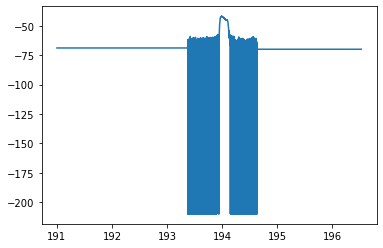

In [82]:
plt.plot(optFreq, optSpectrum)
print(optFreq[2] - optFreq[1])

In [83]:
print(s)
print(e)
wsFreq = np.arange(s, e + 0.001, 0.001)
print(wsFreq)

191.05
196.475
[191.05  191.051 191.052 ... 196.473 196.474 196.475]


In [84]:
# plt.plot(optFreq,optSpectrum)
# plt.show()
# lin_spectrum = [10**(ii/10) for ii in optSpectrum]
# plt.plot(optFreq, lin_spectrum)
# plt.show()
#f = interp1d(optFreq, lin_spectrum, kind='cubic')
f = interp1d(optFreq, optSpectrum, kind='linear')

optSpectrumInterp = f(wsFreq)
#optSpectrumInterp = [10*math.log10(ii) for ii in lin_spectrum]
maxPower = max(optSpectrumInterp)
normPower = -4
calb = 0 # yokuwakaranai


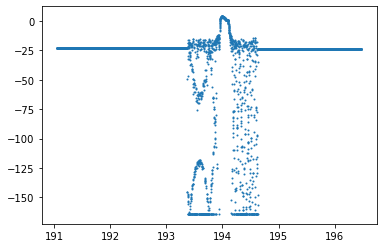

In [85]:
plt.scatter(wsFreq, ((optSpectrumInterp - maxPower) - normPower)  - calb,s=1)

In [86]:

wsAttn = (optSpectrumInterp - maxPower) - normPower - calb
wsPhase = np.zeros(wsFreq.shape)
wsPort = np.ones(wsFreq.shape)
# Upload profile using created data
r = uploadProfile(ip, wsFreq, wsAttn, wsPhase, wsPort)

In [87]:
#np.savetxt("test.wsp", )
instr.close()